# WORK IN PROGRESS

## PDF figure creation

The objective of this notebook is to create all graphs to generate a figure that allows you to look at your datas. 
In this, we want to create functions to create the plots (based on Step-by-Step-Processing), and then to generate an full figure. 
Then, we want to create a PDF that contains the figure. Each page on the PDF should be one session. 

In [119]:
# Imports

import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.path as mpath

from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from processing_TowerCoordinates import *

In [68]:
# Take one mouse as an example

path_to_data_folder = '/home/david/MyLocalData/Maud/'
pattern_of_MOU_Folders = os.path.join(path_to_data_folder, "MOU*")

mice_list: list[str] = ["MOU4521"]

session_list = {}
for mouse in mice_list:
    mouse_folder = os.path.join(path_to_data_folder,mouse)
    session_list[mouse] = sorted([name for name in os.listdir(mouse_folder)
                           if os.path.isdir(os.path.join(mouse_folder, name))
                           and name.startswith('MOU')])
    nb_sessions = len(session_list[mouse])
    print(f'Hello, I\'m {mouse}! I have foraged for {nb_sessions} sessions')
    # print(session_list[mouse], '\n')

Hello, I'm MOU4521! I have foraged for 47 sessions


In [69]:
folder_path_mouse_to_process=os.path.join(path_to_data_folder,mice_list[0])
print(folder_path_mouse_to_process)

session_to_process=session_list[mice_list[0]][0]
print(session_to_process)

/home/david/MyLocalData/Maud/MOU4521
MOU4521_20240430-1143


In [70]:
# Import the pickle file

# Chemin complet vers le fichier pickle
output_pickle_filepath = f"{folder_path_mouse_to_process}/{session_to_process}/{session_to_process}_basic_processing_output.pickle"

# Ouvrir et charger le fichier pickle
with open(output_pickle_filepath, 'rb') as f:
    data = pickle.load(f)

# Afficher les clés du dictionnaire (pickle)
for key, value in data.items():
    print(key)


timeofframes
positions
distances
speeds
angular_speeds
distance_ran
average_speed
all_epochs
run_around_tower_sessionresult
all_trapezes_coordinates_cm
towers_coordinates_cm


In [107]:
# Create some variables from the pickle and calculate total distance ran

X_positions_cm = data['positions'][0]
Y_positions_cm = data['positions'][1]
average_speed = data['average_speed']
distances = data['distances']
speeds = data['speeds']
angular_speeds = data['angular_speeds']
all_epochs = data['all_epochs']
traject_time = data['timeofframes']
run_around_tower_results = data['run_around_tower_sessionresult']
timeofframes = data['timeofframes']
runs_around_tower = all_epochs['run_around_tower']


total_distance = np.sum(distances)/100 # Calculate total distance in meters

In [72]:
# Check how positions datas are organized in the pickle
# Can be deleted once finished

print(f"X positions : {data['positions'][0]}") # X positions
print(f"Y positions : {data['positions'][1]}") # Y positions
print(f"Total distance ran = {round(total_distance,2)}m")


X positions : [ 6.80953875  6.94743006  7.07957129 ... 76.89789047 76.94278417
 76.95277095]
Y positions : [65.62991411 65.09054403 64.35077264 ... 22.25252706 22.25168045
 22.25165563]
Total distance ran = 151.6m


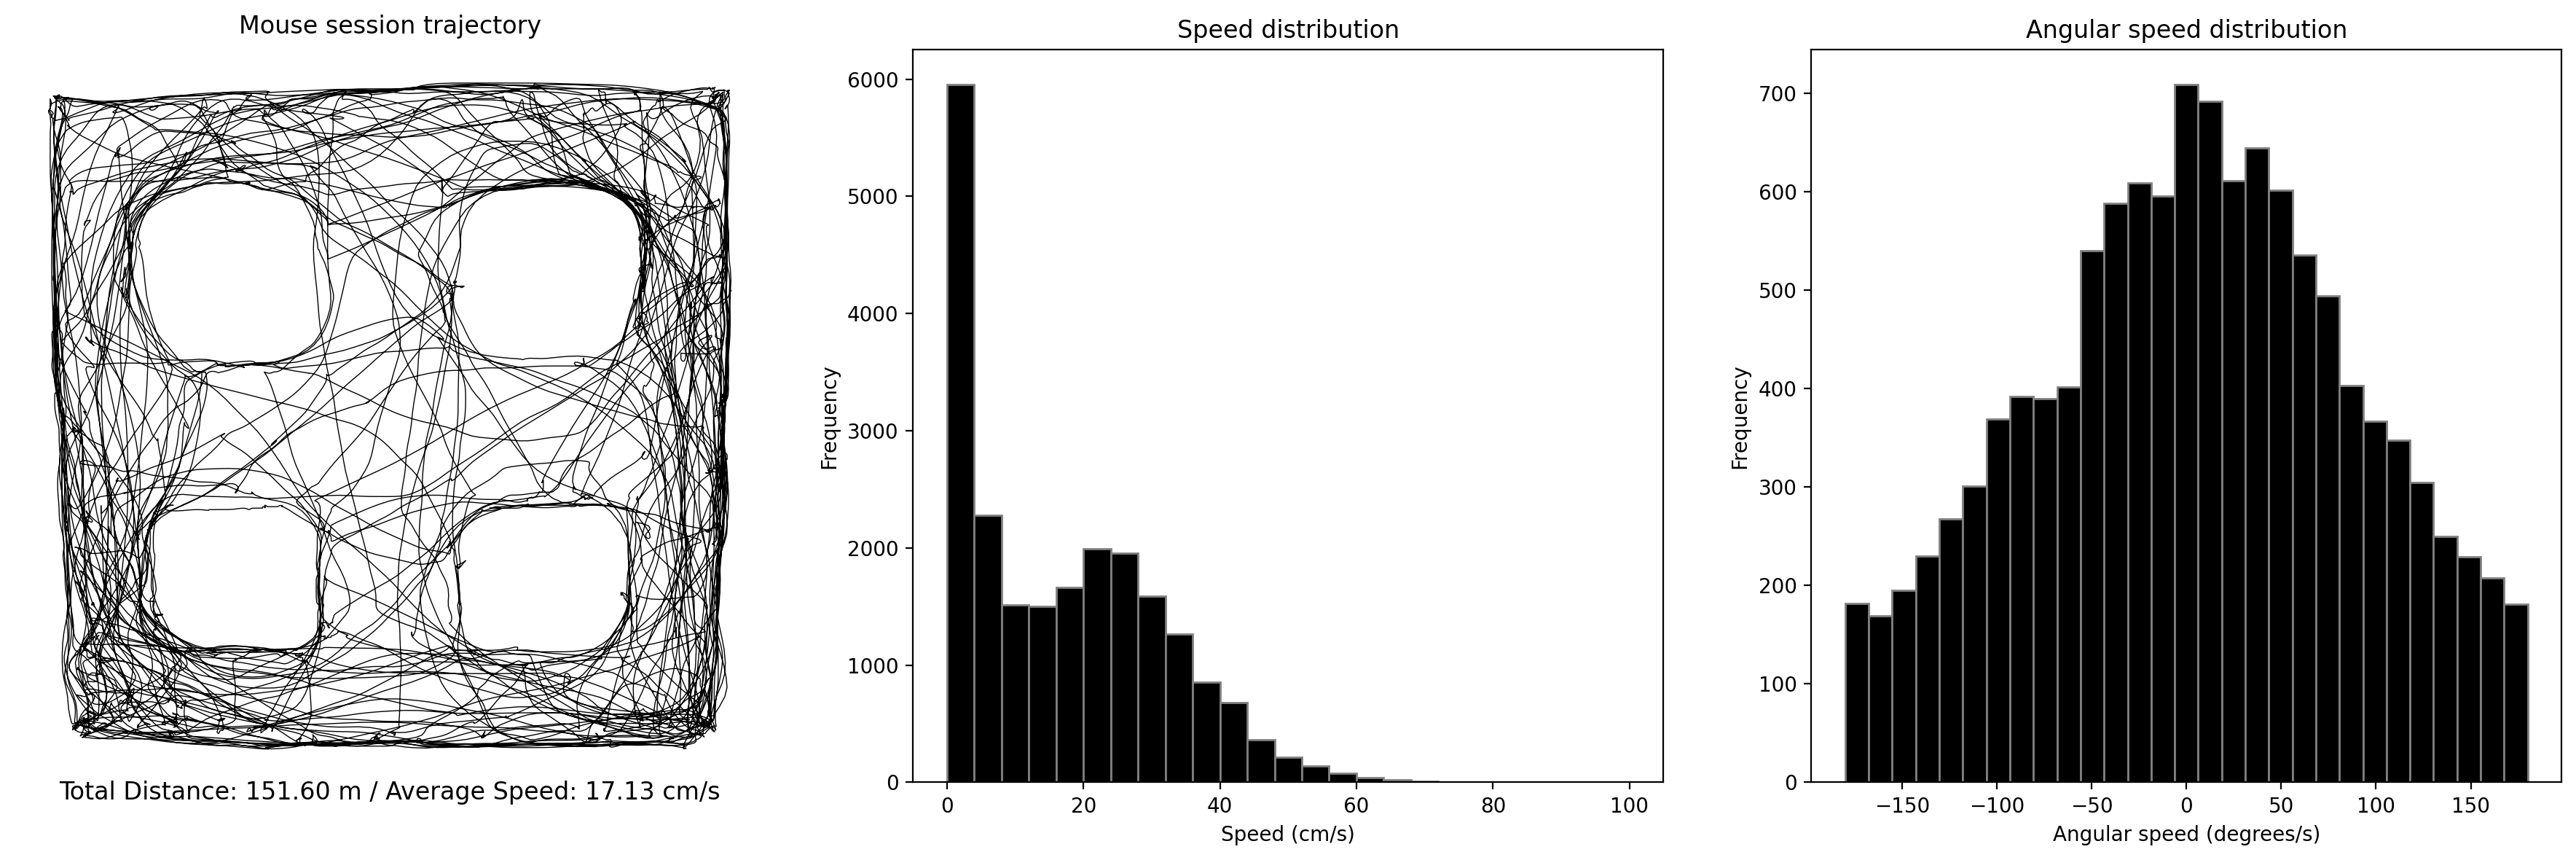

In [73]:
# Functions to plot trajectory, speeds distribution and angular speeds distribution

def plot_trajectory(ax, X_positions_cm, Y_positions_cm, total_distance, average_speed):
    """
    Trace la trajectoire de la souris sur l'axe donné avec la distance totale et la vitesse moyenne.
    """
    ax.plot(X_positions_cm, Y_positions_cm, color='black', linewidth=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title('Mouse session trajectory', pad=8)
    
    # Ajout de la distance totale et de la vitesse moyenne sur le graphique
    text = f"Total Distance: {total_distance:.2f} m / Average Speed: {average_speed:.2f} cm/s"
    ax.text(0.5, -0.03, text, ha='center', va='bottom', transform=ax.transAxes, fontsize=12)

def plot_speed_distribution(ax, speeds):
    """
    Trace l'histogramme de distribution de la vitesse sur l'axe donné.
    """
    bins_speed = np.arange(0, 104, 4)  # Paliers de 4 cm/s jusqu'à 100 cm/s
    ax.hist(speeds, bins=bins_speed, edgecolor='gray', color='k')
    ax.set_title('Speed distribution')
    ax.set_xlabel('Speed (cm/s)')
    ax.set_ylabel('Frequency')

def plot_angular_speed_distribution(ax, angular_speeds):
    """
    Trace l'histogramme de distribution de la vitesse angulaire sur l'axe donné.
    """
    bins_angular_speed = np.linspace(-180, 180, 30)  # Paliers pour les vitesses angulaires
    ax.hist(angular_speeds, bins=bins_angular_speed, edgecolor='gray', color='k')
    ax.set_title('Angular speed distribution')
    ax.set_xlabel('Angular speed (degrees/s)')
    ax.set_ylabel('Frequency')

# Création d'une figure principale avec trois sous-graphiques (subplots)
fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=200)

# Appel de chaque fonction en passant l'axe correspondant
plot_trajectory(axs[0], X_positions_cm, Y_positions_cm, total_distance, average_speed)
plot_speed_distribution(axs[1], speeds)
plot_angular_speed_distribution(axs[2], angular_speeds)

# Ajustement de la disposition
plt.tight_layout()
plt.show()


In [74]:
# Calculate time and distances spent in zones
# TO DO : should go in the processing of trajectory + add the 2 values returned in the pickle

border_zone = [
    [(3, 3), (10, 3), (10, 90), (3, 90)],  # left
    [(3, 3), (3, 9.5), (92, 9.5), (92, 3)],  # down
    [(84, 3), (92, 3), (92, 90), (84, 90)],  # right
    [(3, 83), (3, 90), (92, 90), (92, 83)]   # up
]

def calculate_time_distance_in_zones(folder_path_mouse_to_process, session_to_process, border_zone, trapeze_width, time_start=None, time_end=None):
    """This function is used to calculate the total time spent and total distance traveled in border, inner and trapezes areas during session. 
    Arguments:
    - folder_path_mouse_to_process
    - session_to_process
    - border_zone : dictionnary of coordinates that define the border zone
    - towers_coordinates : dictionnary of towers coordinates in pixel
    - trapeze_width : value in pixel to set up the size of the trapezes

    Outputs: 
    - time_spent_in_zones : dictionnary with area as key and time spent inside as value
    - distance_covered_in_zones : dictionnary with area as key and distance traveled inside as value
    """

    # Build the path to the session pickle file
    pickle_file = os.path.join(folder_path_mouse_to_process, session_to_process, session_to_process + '_basic_processing_output.pickle')
    
    towers_coordinates=get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_process)[1]
    
    # Load data from pickle file
    with open(pickle_file, 'rb') as f:
        session_data = pickle.load(f)
    
    # Extract the necessary data from the pickle in the selected period
    traject_time = session_data['timeofframes'] # replace here
    smoothed_Xpositions_cm = session_data['positions'][0] # replace here
    smoothed_Ypositions_cm = session_data['positions'][1] # replace here
    all_trapezes_coordinates_cm = generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)[0]

    # If None, the entire session will be analyzed
    if time_start is None:
        time_start = traject_time[0]
    if time_end is None:
        time_end = traject_time[-1]

    # Find the indices corresponding to the specified time interval
    start_idx = np.searchsorted(traject_time, time_start)
    end_idx = np.searchsorted(traject_time, time_end)

    # Extract data from the selected period
    selected_Xpositions = smoothed_Xpositions_cm[start_idx:end_idx]
    selected_Ypositions = smoothed_Ypositions_cm[start_idx:end_idx]
    selected_time = traject_time[start_idx:end_idx]

    # Border zones (red)
    border_polygons = [
        mpath.Path(border_zone[0]),  # Left
        mpath.Path(border_zone[1]),  # Down
        mpath.Path(border_zone[2]),  # Right
        mpath.Path(border_zone[3])   # Up
    ]
    
    # Trapezes zones (white)
    trapeze_polygons = []
    for tower, trapezes in all_trapezes_coordinates_cm.items():
        for trapeze, coords in trapezes.items():
            trapeze_polygons.append(mpath.Path(coords))
    
    # Interior zone (green)
    inner_setup_size = (10, 9.5, 84, 83)
    interior_polygon = mpath.Path([
        (inner_setup_size[0], inner_setup_size[1]),
        (inner_setup_size[0], inner_setup_size[3]),
        (inner_setup_size[2], inner_setup_size[3]),
        (inner_setup_size[2], inner_setup_size[1])
    ])
    
    # Variables to store time/distance spent in each zone
    time_in_border = 0
    time_in_trapeze = 0
    time_in_interior = 0
    distance_in_border = 0
    distance_in_trapeze = 0
    distance_in_interior = 0
    
    # Browse the trajectory positions and calculate the time and distance in each area
    for i in range(len(selected_Xpositions) - 1):
        point_start = np.array([selected_Xpositions[i], selected_Ypositions[i]])
        point_end = np.array([selected_Xpositions[i+1], selected_Ypositions[i+1]])

        # Calculate the time interval between each point
        dt = selected_time[i+1] - selected_time[i]
        
        # Calculate the distance between two successive points
        distance = np.linalg.norm(point_end - point_start)

        # Test if the initial point is in the 'border' zone (red)
        if any(polygon.contains_point(point_start) for polygon in border_polygons):
            time_in_border += dt
            distance_in_border += distance

        # Test if the initial point is in the 'trapeze' (white) area
        elif any(polygon.contains_point(point_start) for polygon in trapeze_polygons):
            time_in_trapeze += dt
            distance_in_trapeze += distance

        # Test if the initial point is in the inner (green) zone
        elif interior_polygon.contains_point(point_start):
            time_in_interior += dt
            distance_in_interior += distance

    # Return results in a dictionary, rounded to 2 decimal
    time_spent_in_zones = {
        'border': round(time_in_border, 2),
        'trapeze': round(time_in_trapeze, 2),
        'interior': round(time_in_interior, 2)
    }

    distance_covered_in_zones = {
        'border': round(distance_in_border, 2),
        'trapeze': round(distance_in_trapeze, 2),
        'interior': round(distance_in_interior, 2)
    }
    
    return time_spent_in_zones, distance_covered_in_zones

In [75]:
# Example usage of the function above

# Calculate the time spent in each zone
time_spent_in_zones, distance_covered_in_zones = calculate_time_distance_in_zones(folder_path_mouse_to_process, session_to_process, border_zone, trapeze_width=40, time_start=None, time_end=None)

time_in_border = time_spent_in_zones['border']
time_in_trapeze = time_spent_in_zones['trapeze']
time_in_interior = time_spent_in_zones['interior']
distance_in_border = distance_covered_in_zones['border']
distance_in_trapeze = distance_covered_in_zones['trapeze']
distance_in_interior = distance_covered_in_zones['interior']
# These variables should go at the begining once the function is added to the pickle generation


In [100]:
# Calculate the time and distance ratios between trapeze and border
# TO DO : go up once function pickled

ratio_time_trapeze_border = time_in_trapeze / time_in_border
ratio_distance_trapeze_border = distance_in_trapeze / distance_in_border

# Calculate speed for each zone
speed_border = distance_in_border / time_in_border
speed_trapezes = distance_in_trapeze / time_in_trapeze
speed_interior = distance_in_interior / time_in_interior

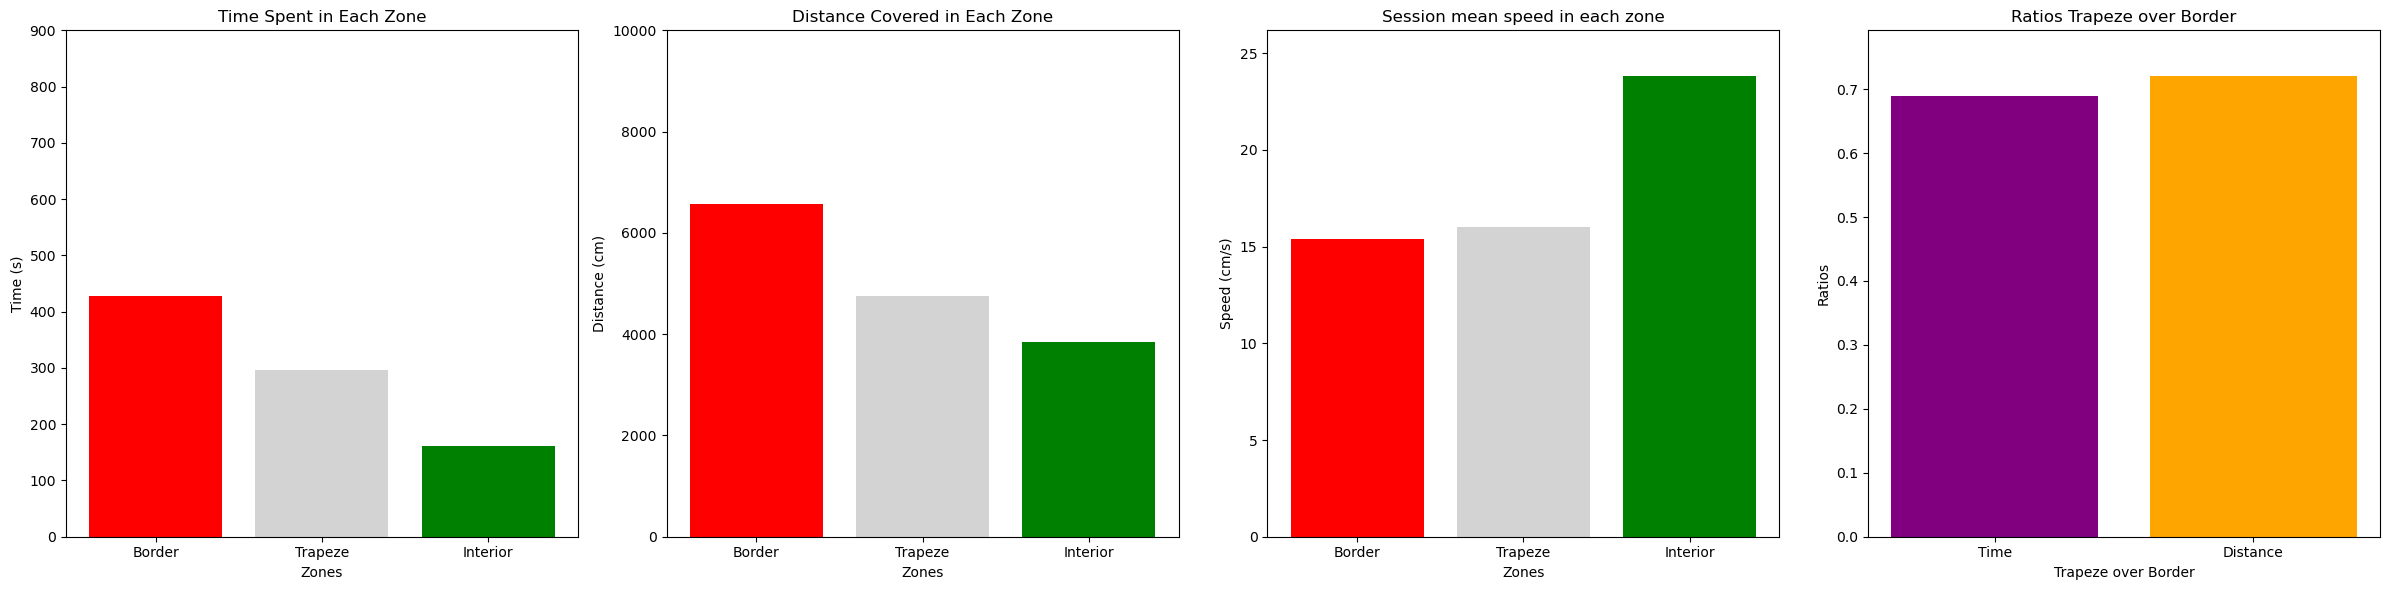

In [ ]:
# To be deleted at the end
# Functions to plot time/distances/speeds and ratios regarding zones analysis

# def plot_time_in_zones(ax, zones, time_data, colors):
#     """
#     Trace le temps passé dans chaque zone.
    
#     Paramètres :
#         ax : L'axe sur lequel dessiner le graphique.
#         zones (list) : Liste des zones.
#         time_data (list) : Temps passé dans chaque zone.
#         colors (list) : Couleurs associées à chaque zone.
#     """
#     ax.bar(zones, time_data, color=colors)
#     ax.set_title('Time Spent in Each Zone')
#     ax.set_xlabel('Zones')
#     ax.set_ylabel('Time (s)')
#     ax.set_ylim(0,900)
#     # ax.set_ylim(0, max(time_data) * 1.1)  # Laisser de l'espace au-dessus des barres


# def plot_distance_in_zones(ax, zones, distance_data, colors):
#     """
#     Trace la distance parcourue dans chaque zone.
    
#     Paramètres :
#         ax : L'axe sur lequel dessiner le graphique.
#         zones (list) : Liste des zones.
#         distance_data (list) : Distance parcourue dans chaque zone.
#         colors (list) : Couleurs associées à chaque zone.
#     """
#     ax.bar(zones, distance_data, color=colors)
#     ax.set_title('Distance Covered in Each Zone')
#     ax.set_xlabel('Zones')
#     ax.set_ylabel('Distance (cm)')
#     ax.set_ylim(0,10000)
#     # ax.set_ylim(0, max(distance_data) * 1.1)  # Laisser de l'espace au-dessus des barres

# def plot_speed_in_zones(ax, zones, speed_data, colors):
#     ax.bar(zones, speed_data, color=colors)
#     ax.set_title('Session mean speed in each zone')
#     ax.set_xlabel('Zones')
#     ax.set_ylabel('Speed (cm/s)')
#     ax.set_ylim(0, max(speed_data) * 1.1)


# def plot_ratios_trapeze_over_border(ax, ratios, ratios_data, colors):
#     """
#     Trace les ratios trapèze/bordure pour le temps et la distance.
    
#     Paramètres :
#         ax : L'axe sur lequel dessiner le graphique.
#         ratios (list) : Liste contenant les types de ratios (par ex. ['Time', 'Distance']).
#         ratios_data (list) : Valeurs des ratios.
#         colors (list) : Couleurs associées à chaque ratio.
#     """
#     ax.bar(ratios, ratios_data, color=colors)
#     ax.set_title('Ratios Trapeze over Border')
#     ax.set_xlabel('Trapeze over Border')
#     ax.set_ylabel('Ratios')
#     ax.set_ylim(0, max(ratios_data) * 1.1)  # Laisser de l'espace au-dessus des barres


# # Exemple d'utilisation de chaque fonction pour créer les trois graphiques côte à côte

# fig, axs = plt.subplots(1, 4, figsize=(24, 6))

# # Données d'exemple pour chaque fonction
# zones = ['Border', 'Trapeze', 'Interior']
# colors_zones = ['red', 'lightgray', 'green']
# time_data = [time_in_border, time_in_trapeze, time_in_interior]
# distance_data = [distance_in_border, distance_in_trapeze, distance_in_interior]
# speed_data = [speed_border, speed_trapezes, speed_interior]
# ratios_columns_titles = ['Time', 'Distance']
# ratios_trapeze_over_border = [round(ratio_time_trapeze_border, 2), round(ratio_distance_trapeze_border, 2)]
# colors_ratios = ['purple', 'orange']

# # Appel des fonctions pour tracer les graphiques dans les sous-graphiques respectifs
# plot_time_in_zones(axs[0], zones, time_data, colors_zones)
# plot_distance_in_zones(axs[1], zones, distance_data, colors_zones)
# plot_speed_in_zones(axs[2], zones, speed_data, colors_zones)
# plot_ratios_trapeze_over_border(axs[3], ratios_columns_titles, ratios_trapeze_over_border, colors_ratios)

# # Ajustement de l'espacement entre les sous-graphiques
# plt.tight_layout()
# plt.show()


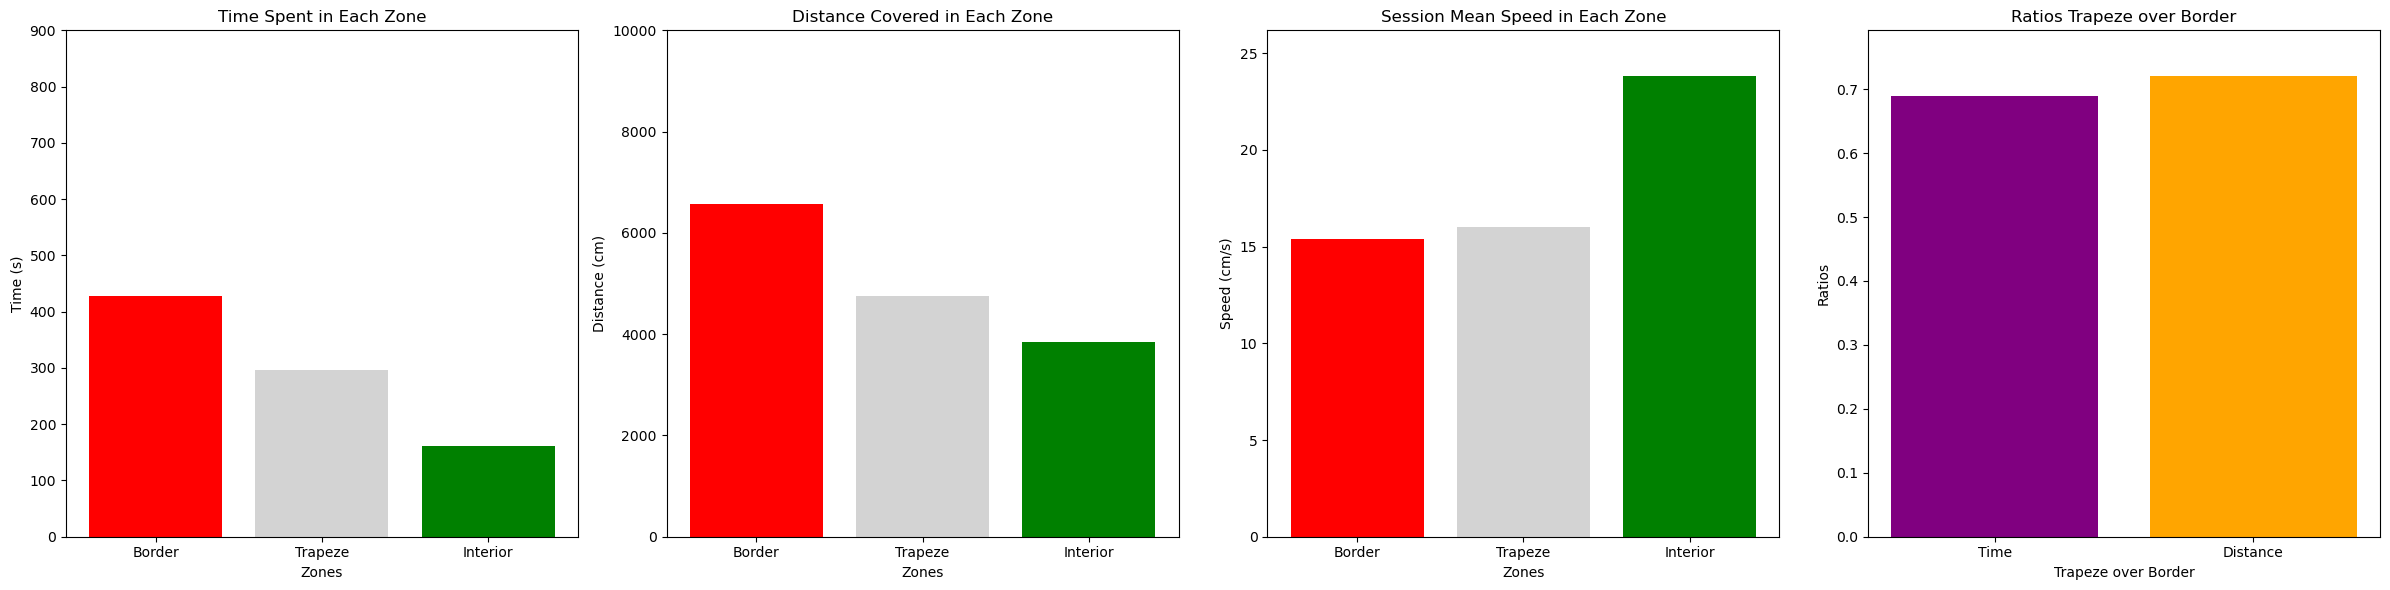

In [121]:
import matplotlib.pyplot as plt

def plot_metrics_in_zones(axs, zones, time_data, distance_data, speed_data, 
                          ratios_columns_titles, ratios_trapeze_over_border, 
                          colors_zones, colors_ratios):
    """
    Crée une figure avec plusieurs sous-graphiques pour afficher différentes métriques
    (temps, distance, vitesse et ratios) dans chaque zone.
    
    Paramètres :
        fig : La figure sur laquelle ajouter les sous-graphiques.
        zones (list) : Liste des zones.
        time_data (list) : Liste des temps passés dans chaque zone.
        distance_data (list) : Liste des distances parcourues dans chaque zone.
        speed_data (list) : Liste des vitesses moyennes dans chaque zone.
        ratios_columns_titles (list) : Liste des titres des ratios ('Time', 'Distance').
        ratios_trapeze_over_border (list) : Valeurs des ratios trapèze/bordure.
        colors_zones (list) : Liste des couleurs associées à chaque zone.
        colors_ratios (list) : Liste des couleurs associées aux ratios.
    """
    # Crée les sous-graphes
    # axs = fig.subplots(1, 4)

    # Tracer le temps passé dans chaque zone
    axs[0].bar(zones, time_data, color=colors_zones)
    axs[0].set_title('Time Spent in Each Zone')
    axs[0].set_xlabel('Zones')
    axs[0].set_ylabel('Time (s)')
    axs[0].set_ylim(0, 900)  # Ajuste la limite y si nécessaire
    
    # Tracer la distance parcourue dans chaque zone
    axs[1].bar(zones, distance_data, color=colors_zones)
    axs[1].set_title('Distance Covered in Each Zone')
    axs[1].set_xlabel('Zones')
    axs[1].set_ylabel('Distance (cm)')
    axs[1].set_ylim(0, 10000)  # Ajuste la limite y si nécessaire
    
    # Tracer la vitesse dans chaque zone
    axs[2].bar(zones, speed_data, color=colors_zones)
    axs[2].set_title('Session Mean Speed in Each Zone')
    axs[2].set_xlabel('Zones')
    axs[2].set_ylabel('Speed (cm/s)')
    axs[2].set_ylim(0, max(speed_data) * 1.1)  # Ajuste la limite y si nécessaire

    # Tracer les ratios trapèze/bordure pour le temps et la distance
    axs[3].bar(ratios_columns_titles, ratios_trapeze_over_border, color=colors_ratios)
    axs[3].set_title('Ratios Trapeze over Border')
    axs[3].set_xlabel('Trapeze over Border')
    axs[3].set_ylabel('Ratios')
    axs[3].set_ylim(0, max(ratios_trapeze_over_border) * 1.1)  # Ajuste la limite y si nécessaire

    # Ajuster l'espacement entre les sous-graphiques
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation de la fonction
zones = ['Border', 'Trapeze', 'Interior']
colors_zones = ['red', 'lightgray', 'green']
time_data = [time_in_border, time_in_trapeze, time_in_interior]
distance_data = [distance_in_border, distance_in_trapeze, distance_in_interior]
speed_data = [speed_border, speed_trapezes, speed_interior]
ratios_columns_titles = ['Time', 'Distance']
ratios_trapeze_over_border = [round(ratio_time_trapeze_border, 2), round(ratio_distance_trapeze_border, 2)]
colors_ratios = ['purple', 'orange']

# Création de la figure
fig_metrics = plt.figure(figsize=(24, 6))
axs = fig_metrics.subplots(1, 4)

# Appel de la fonction pour créer la figure avec les sous-graphiques
plot_metrics_in_zones(axs, zones, time_data, distance_data, speed_data, 
                      ratios_columns_titles, ratios_trapeze_over_border, 
                      colors_zones, colors_ratios)


In [118]:
# Correction de la fonction du dessus pour la grid 

def plot_metrics_in_zones(ax, zones, time_data, distance_data, speed_data, 
                          ratios_columns_titles, ratios_trapeze_over_border, 
                          colors_zones, colors_ratios):
    """
    Cette fonction dessine quatre graphiques sur un axe principal unique
    en divisant cet axe en une grille interne 1x4, sans utiliser de liste `axs`.
    
    Parameters:
    - ax: Axe principal dans lequel les sous-graphiques sont dessinés
    - zones: Liste des zones (ex. ['Border', 'Trapeze', 'Interior'])
    - time_data, distance_data, speed_data: Données pour chaque zone
    - ratios_columns_titles, ratios_trapeze_over_border: Données pour les ratios trapèze/bordure
    - colors_zones, colors_ratios: Couleurs associées aux zones et aux ratios
    """
    # Divise l'axe principal en une grille 1x4 pour les sous-graphiques
    gs_inner = GridSpecFromSubplotSpec(1, 4, subplot_spec=ax.get_subplotspec(), wspace=0.5)

    # Sous-graphe 1: Temps dans chaque zone
    ax_time = ax.figure.add_subplot(gs_inner[0])
    ax_time.bar(zones, time_data, color=colors_zones)
    ax_time.set_title('Time Spent in Each Zone')
    ax_time.set_xlabel('Zones')
    ax_time.set_ylabel('Time (s)')
    ax_time.set_ylim(0, 900)

    # Sous-graphe 2: Distance dans chaque zone
    ax_distance = ax.figure.add_subplot(gs_inner[1])
    ax_distance.bar(zones, distance_data, color=colors_zones)
    ax_distance.set_title('Distance Covered in Each Zone')
    ax_distance.set_xlabel('Zones')
    ax_distance.set_ylabel('Distance (cm)')
    ax_distance.set_ylim(0, 10000)

    # Sous-graphe 3: Vitesse moyenne dans chaque zone
    ax_speed = ax.figure.add_subplot(gs_inner[2])
    ax_speed.bar(zones, speed_data, color=colors_zones)
    ax_speed.set_title('Session Mean Speed in Each Zone')
    ax_speed.set_xlabel('Zones')
    ax_speed.set_ylabel('Speed (cm/s)')
    ax_speed.set_ylim(0, max(speed_data) * 1.1)

    # Sous-graphe 4: Ratios trapèze/bordure pour le temps et la distance
    ax_ratios = ax.figure.add_subplot(gs_inner[3])
    ax_ratios.bar(ratios_columns_titles, ratios_trapeze_over_border, color=colors_ratios)
    ax_ratios.set_title('Ratios Trapeze over Border')
    ax_ratios.set_xlabel('Trapeze over Border')
    ax_ratios.set_ylabel('Ratios')
    ax_ratios.set_ylim(0, max(ratios_trapeze_over_border) * 1.1)

    # Ajustement des espaces entre les sous-graphiques
    plt.tight_layout()
    plt.show()

### Plot QT related graphs

In [ ]:
# Create a color map for further analysis

def custom_cmap(num_points):
    colors = [(0, 1, 0), (1, 0.5, 0), (1, 0, 0)] # Green to orange to red
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
    return [cmap(i / (num_points - 1)) for i in range(num_points)]


In [79]:
# Extract CW and CCW info from pickle here 

all_results_CW_CCW = run_around_tower_results['All']

# Extraire les valeurs spécifiques
total_CW = all_results_CW_CCW['total_CW']
total_CCW = all_results_CW_CCW['total_CCW']
rewarded_CW = all_results_CW_CCW['rewarded_CW']
rewarded_CCW = all_results_CW_CCW['rewarded_CCW']

# Afficher les résultats
print("total_CW:", total_CW)
print("total_CCW:", total_CCW)
print("rewarded_CW:", rewarded_CW)
print("rewarded_CCW:", rewarded_CCW)


total_CW: 19
total_CCW: 12
rewarded_CW: 0
rewarded_CCW: 1


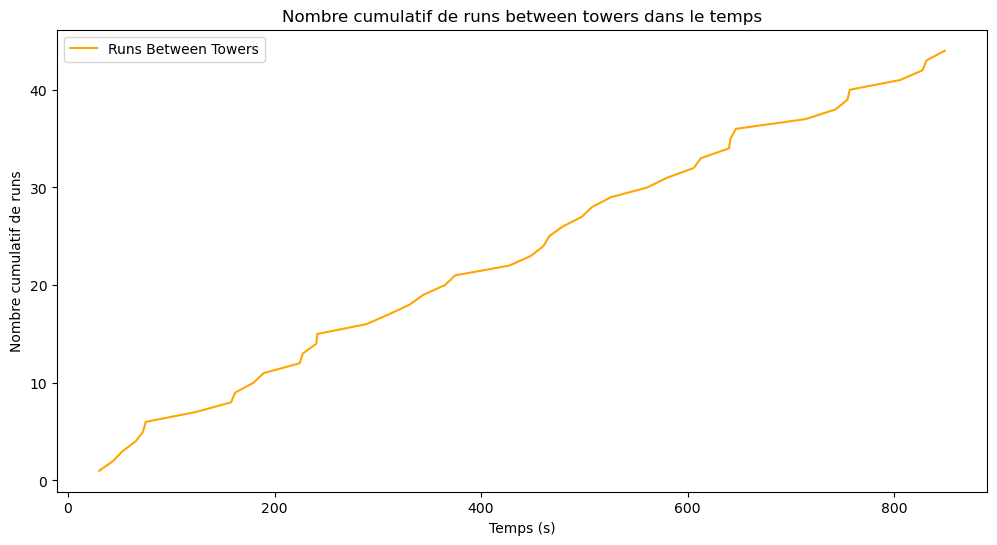

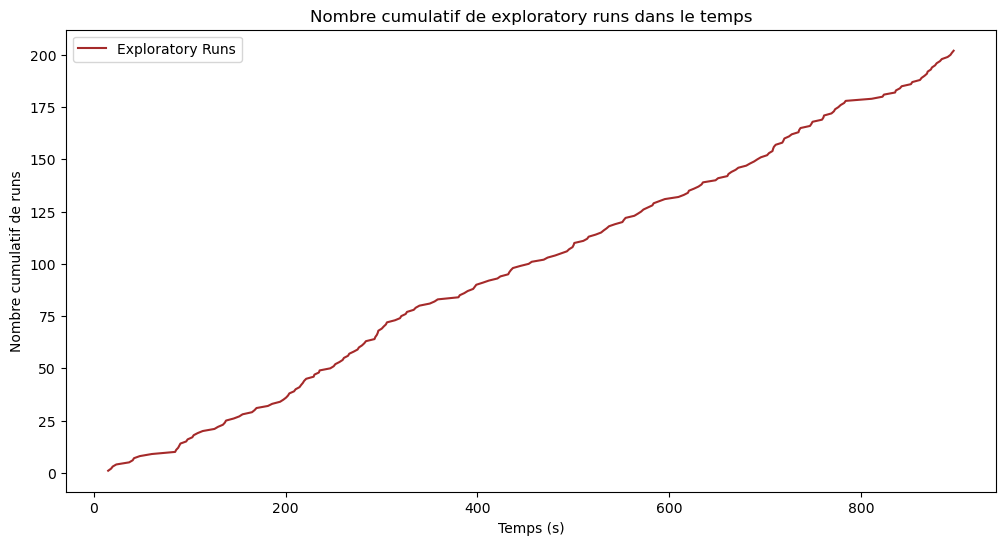

In [84]:
# Plot the cumulative number of run between towers and exploratory runs
# TO DO : transform into a function where you choose the run type again
# TO DO BONUS : create a cell at the begining of the code to define every variable

# Extraire les données des runs between towers et exploratory runs
runs_between_towers = data['all_epochs']['run_between_towers']
exploratory_runs = data['all_epochs']['exploratory_run']

# Obtenir les temps de début pour chaque catégorie
between_towers_times = [run[3]['time'] for run in runs_between_towers]
exploratory_run_times = [run[3]['time'] for run in exploratory_runs]

# Convertir les listes en tableaux numpy et les trier
between_towers_times = np.sort(np.array(between_towers_times))
exploratory_run_times = np.sort(np.array(exploratory_run_times))

# Calculer le cumulatif pour chaque catégorie
between_towers_cumulative = np.arange(1, len(between_towers_times) + 1)
exploratory_run_cumulative = np.arange(1, len(exploratory_run_times) + 1)

# Création du graphique pour le cumulatif des runs between towers
plt.figure(figsize=(12, 6))
plt.plot(between_towers_times, between_towers_cumulative, label='Runs Between Towers', color='orange')
plt.xlabel('Temps (s)')
plt.ylabel('Nombre cumulatif de runs')
plt.title('Nombre cumulatif de runs between towers dans le temps')
plt.legend()

# Afficher le premier graphique
plt.show()

# Création du graphique pour le cumulatif des exploratory runs
plt.figure(figsize=(12, 6))
plt.plot(exploratory_run_times, exploratory_run_cumulative, label='Exploratory Runs', color='brown')
plt.xlabel('Temps (s)')
plt.ylabel('Nombre cumulatif de runs')
plt.title('Nombre cumulatif de exploratory runs dans le temps')
plt.legend()

# Afficher le deuxième graphique
plt.show()


In [ ]:
print(runs_around_tower) # test
print(runs_between_towers)
print(exploratory_runs)

[[[775, 812], ['NE', 'W'], ['NE', 'N'], {'Rewarded': False, 'direction': 'CW', 'num_trapezeswitch': 1}, {'epoch_time': 46.036, 'epoch_duration': 1.4799999999999969, 'epoch_distance': 29.882937873246007, 'epoch_meanspeed': 20.19117423867978, 'epoch_maxspeed': 33.98805715100728}], [[1062, 1092], ['SW', 'E'], ['SW', 'S'], {'Rewarded': False, 'direction': 'CW', 'num_trapezeswitch': 1}, {'epoch_time': 57.522, 'epoch_duration': 1.2010000000000005, 'epoch_distance': 13.95897432466937, 'epoch_meanspeed': 11.622792943105216, 'epoch_maxspeed': 20.434362742578973}], [[1330, 1355], ['NE', 'W'], ['NE', 'N'], {'Rewarded': False, 'direction': 'CW', 'num_trapezeswitch': 1}, {'epoch_time': 68.245, 'epoch_duration': 1.0039999999999907, 'epoch_distance': 16.996944733687904, 'epoch_meanspeed': 16.929227822398467, 'epoch_maxspeed': 30.710476422282166}], [[1400, 1440], ['NE', 'N'], ['NE', 'W'], {'Rewarded': False, 'direction': 'CCW', 'num_trapezeswitch': 1}, {'epoch_time': 71.048, 'epoch_duration': 1.602000

In [87]:
runs_around_tower[0] # test

[[775, 812],
 ['NE', 'W'],
 ['NE', 'N'],
 {'Rewarded': False, 'direction': 'CW', 'num_trapezeswitch': 1},
 {'epoch_time': 46.036,
  'epoch_duration': 1.4799999999999969,
  'epoch_distance': 29.882937873246007,
  'epoch_meanspeed': 20.19117423867978,
  'epoch_maxspeed': 33.98805715100728}]

In [88]:
# Function to plot centered trajectory for a specific run type
# TO DO : incorporate direction for runs around tower

def plot_trajectory_type_centered(ax, smoothed_Xpositions, smoothed_Ypositions, run_type, title_type = 'run not defined', axis_lim=80, direction='None', q=4):
    """
    Trace la trajectoire de la souris pour le type de run spécifié.
    
    Paramètres :
        ax : Axe matplotlib sur lequel dessiner le graphique.
        smoothed_Xpositions (list) : Positions X lissées.
        smoothed_Ypositions (list) : Positions Y lissées.
        run_type (str) : Type de run ('run_between_towers', 'exploratory_run', 'run_around_tower').
        q (int) : Nombre de points pour calculer la flèche de direction.
    """
    # if run_type == 'run_around_tower' and direction is not None:
    #     runs = all_epochs[run_type]
    # runs = all_epochs[run_type]

    fixed_origin = (0, 0)
    cmap = plt.cm.copper
    norm = Normalize(vmin=0, vmax=len(run_type))

    for index, run in enumerate(run_type):
        start_index, end_index = run[0][0], run[0][1]

        # Extraction des positions X et Y pour cette période de run
        runtype_epoch_Xpositions = smoothed_Xpositions[start_index:end_index + 1]
        runtype_epoch_Ypositions = smoothed_Ypositions[start_index:end_index + 1]
        numberofpositions = len(runtype_epoch_Xpositions)
        colorgradientforthisrun = custom_cmap(numberofpositions)
        
        # Translation de la trajectoire pour que le point de départ soit à l'origine
        start_x, start_y = runtype_epoch_Xpositions[0], runtype_epoch_Ypositions[0]
        translated_Xpositions = [x - start_x + fixed_origin[0] for x in runtype_epoch_Xpositions]
        translated_Ypositions = [y - start_y + fixed_origin[1] for y in runtype_epoch_Ypositions]
        
        # Tracé de la trajectoire
        for i in range(numberofpositions - 1):
            ax.plot(translated_Xpositions[i:i+2], translated_Ypositions[i:i+2], color=colorgradientforthisrun[i])
        
        # Point de départ en vert
        ax.plot(translated_Xpositions[0], translated_Ypositions[0], 'go', markersize=3)
        
        # Tracé de la flèche directionnelle
        if len(translated_Xpositions) >= q:
            dx = translated_Xpositions[-1] - translated_Xpositions[-q]
            dy = translated_Ypositions[-1] - translated_Ypositions[-q]
            
            norm_speed = np.hypot(dx, dy)
            if norm_speed != 0:
                dx /= norm_speed
                dy /= norm_speed
            
            ax.arrow(translated_Xpositions[-1], translated_Ypositions[-1], dx, dy,
                     head_width=1, head_length=1, fc='red', ec='red')

    ax.set_ylabel('Y Position (cm)')
    ax.set_xlabel('X Position (cm)')
    ax.set_xlim(-axis_lim, axis_lim)
    ax.set_ylim(-axis_lim, axis_lim)

    ax.set_title(f"Trajectoire centrée pour {title_type}")


In [89]:
# Function to plot speed profile of a specific run type

def plot_speed_over_time(ax, traject_time, speeds, run_type, title_type = 'run not defined',xlim=5.1):
    """
    Trace la vitesse de la souris en fonction du temps pour le type de run spécifié.
    
    Paramètres :
        ax : Axe matplotlib sur lequel dessiner le graphique.
        traject_time (list) : Temps de la trajectoire.
        speeds (list) : Vitesse de la souris.
        runs (list) : Liste des runs pour le type spécifié.
        run_type (str) : Type de run ('between_towers', 'exploratory', 'around_tower').
        color_map (Colormap) : Colormap pour le gradient de couleur.
    """

    # runs = all_epochs[run_type]

    norm = Normalize(vmin=0, vmax=len(run_type))
    color_map = plt.cm.copper
    
    for index, run in enumerate(run_type):
        start_index, end_index = run[0][0], run[0][1]
        adjusted_time = [t - traject_time[start_index] for t in traject_time[start_index:end_index + 1]]
        
        # Tracé de la vitesse
        ax.plot(adjusted_time, speeds[start_index:end_index + 1], color=color_map(norm(index)))

    ax.set_ylabel('Speed (cm/s)')
    ax.set_xlabel('Time (s)')
    ax.set_ylim(0, 80)
    ax.set_xlim(0, xlim)
    
    ax.set_title(f"Vitesse en fonction du temps pour {title_type}")


In [131]:
runs_around_tower_CW = []
runs_around_tower_CCW = []

for run in runs_around_tower:
    if run[3]['direction'] == 'CW':
        runs_around_tower_CW.append(run)
    else:
        runs_around_tower_CCW.append(run)

print(runs_around_tower_CCW)
print(runs_around_tower_CW)

[[[1400, 1440], ['NE', 'N'], ['NE', 'W'], {'Rewarded': False, 'direction': 'CCW', 'num_trapezeswitch': 1}, {'epoch_time': 71.048, 'epoch_duration': 1.6020000000000039, 'epoch_distance': 31.93127594575902, 'epoch_meanspeed': 19.932132300723435, 'epoch_maxspeed': 36.3387051581669}], [[3248, 3267], ['SE', 'W'], ['SE', 'S'], {'Rewarded': False, 'direction': 'CCW', 'num_trapezeswitch': 1}, {'epoch_time': 145.007, 'epoch_duration': 0.7609999999999957, 'epoch_distance': 9.138585092037879, 'epoch_meanspeed': 12.008653208985454, 'epoch_maxspeed': 23.292626858749145}], [[6233, 6248], ['NE', 'S'], ['NE', 'E'], {'Rewarded': False, 'direction': 'CCW', 'num_trapezeswitch': 1}, {'epoch_time': 264.472, 'epoch_duration': 0.6000000000000227, 'epoch_distance': 9.029157683886101, 'epoch_meanspeed': 15.048596139809598, 'epoch_maxspeed': 27.774742616693487}], [[7433, 7461], ['SW', 'E'], ['SW', 'N'], {'Rewarded': False, 'direction': 'CCW', 'num_trapezeswitch': 1}, {'epoch_time': 312.497, 'epoch_duration': 1.

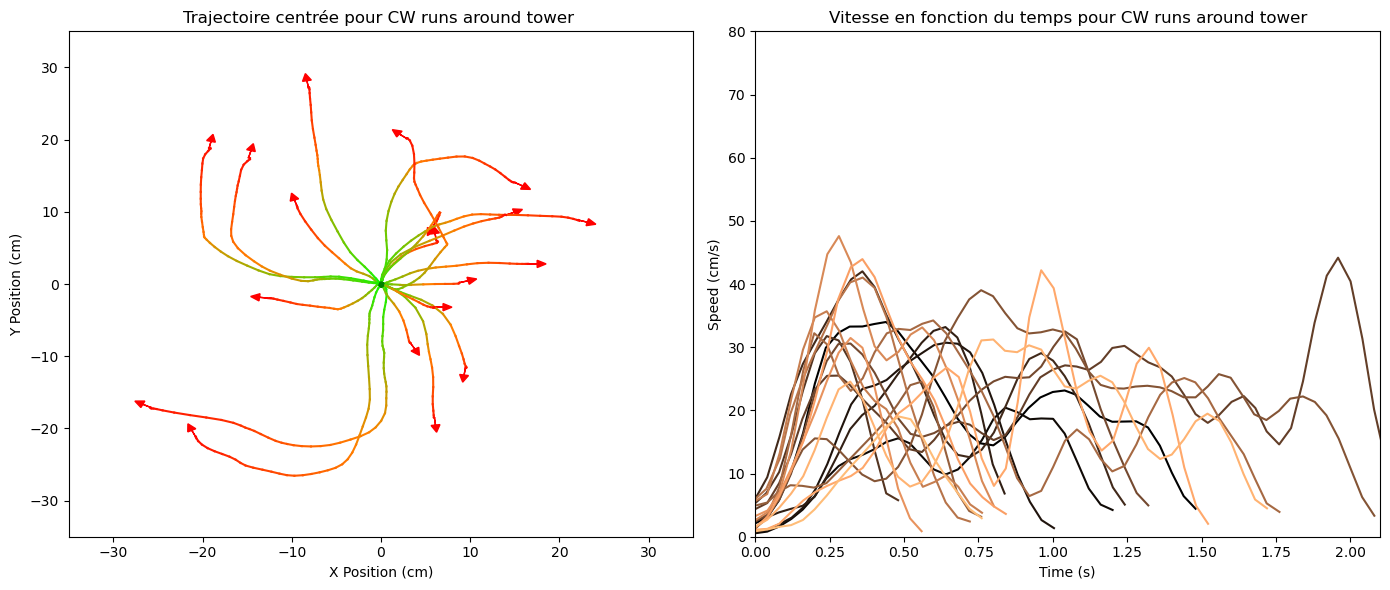

In [132]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

plot_trajectory_type_centered(axs[0], X_positions_cm, Y_positions_cm, runs_around_tower_CW, title_type='CW runs around tower ', axis_lim=35)
plot_speed_over_time(axs[1], traject_time, speeds, runs_around_tower_CW, title_type = 'CW runs around tower',xlim=2.1)

plt.tight_layout()
plt.show()

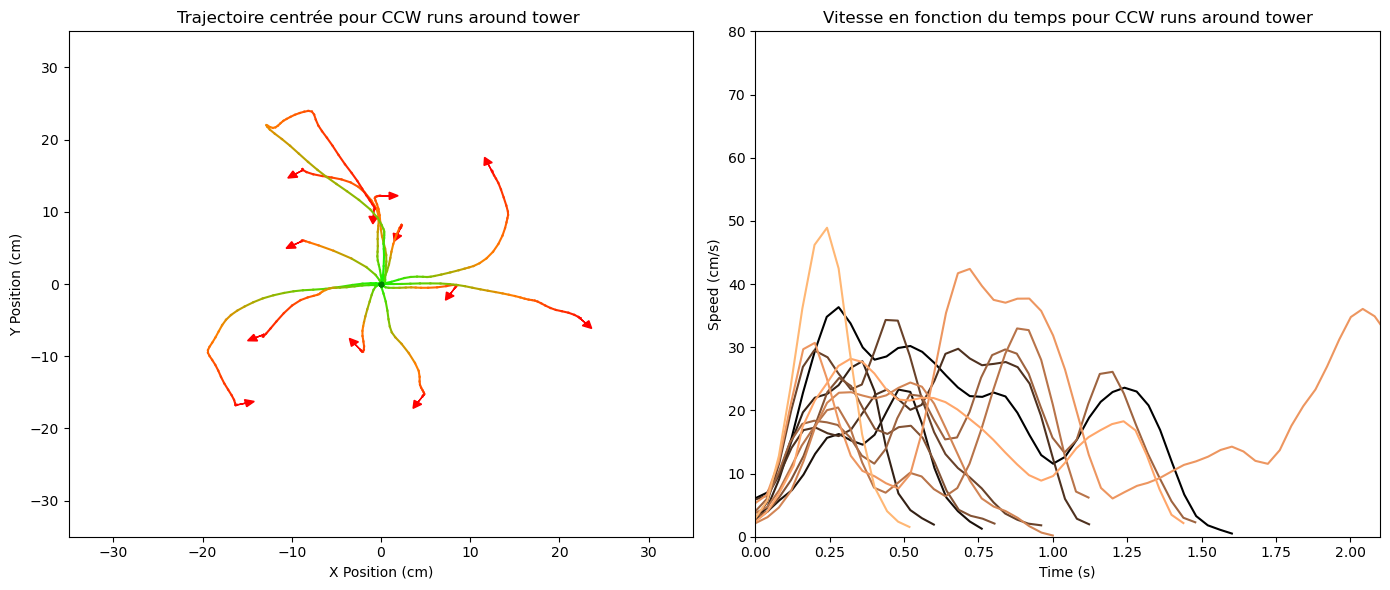

In [133]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

plot_trajectory_type_centered(axs[0], X_positions_cm, Y_positions_cm, runs_around_tower_CCW, title_type='CCW runs around tower ', axis_lim=35)
plot_speed_over_time(axs[1], traject_time, speeds, runs_around_tower_CCW, title_type = 'CCW runs around tower',xlim=2.1)

plt.tight_layout()
plt.show()

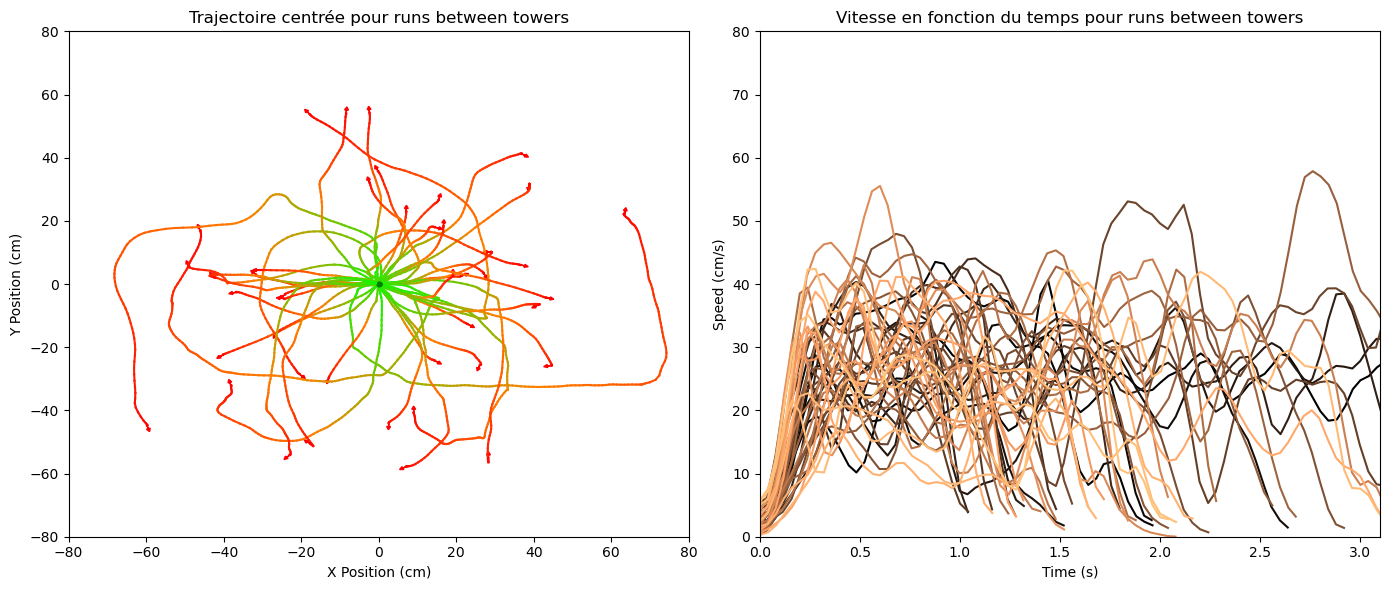

In [91]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

plot_trajectory_type_centered(axs[0], X_positions_cm, Y_positions_cm, runs_between_towers, title_type = 'runs between towers')
plot_speed_over_time(axs[1], traject_time, speeds, runs_between_towers, title_type = 'runs between towers', xlim=3.1)

plt.tight_layout()
plt.show()


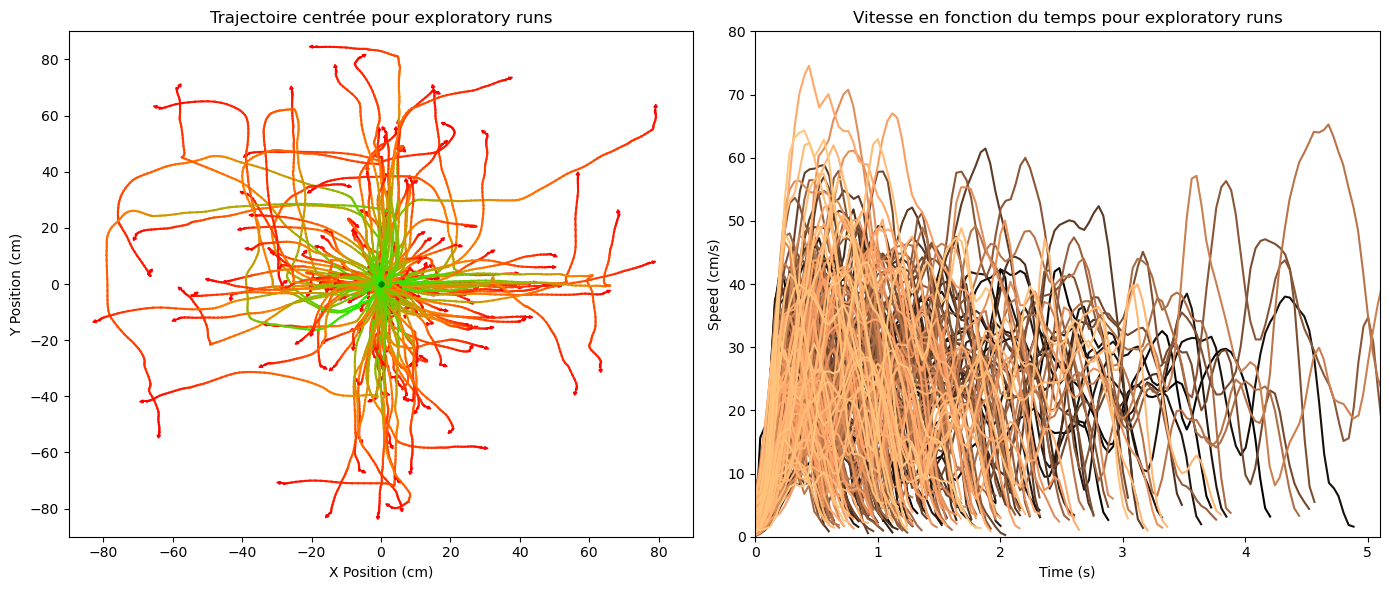

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

plot_trajectory_type_centered(axs[0], X_positions_cm, Y_positions_cm, exploratory_runs, title_type='exploratory runs', axis_lim=90)
plot_speed_over_time(axs[1], traject_time, speeds, exploratory_runs, title_type = 'exploratory runs')

plt.tight_layout()
plt.show()

TypeError: 'AxesSubplot' object is not subscriptable

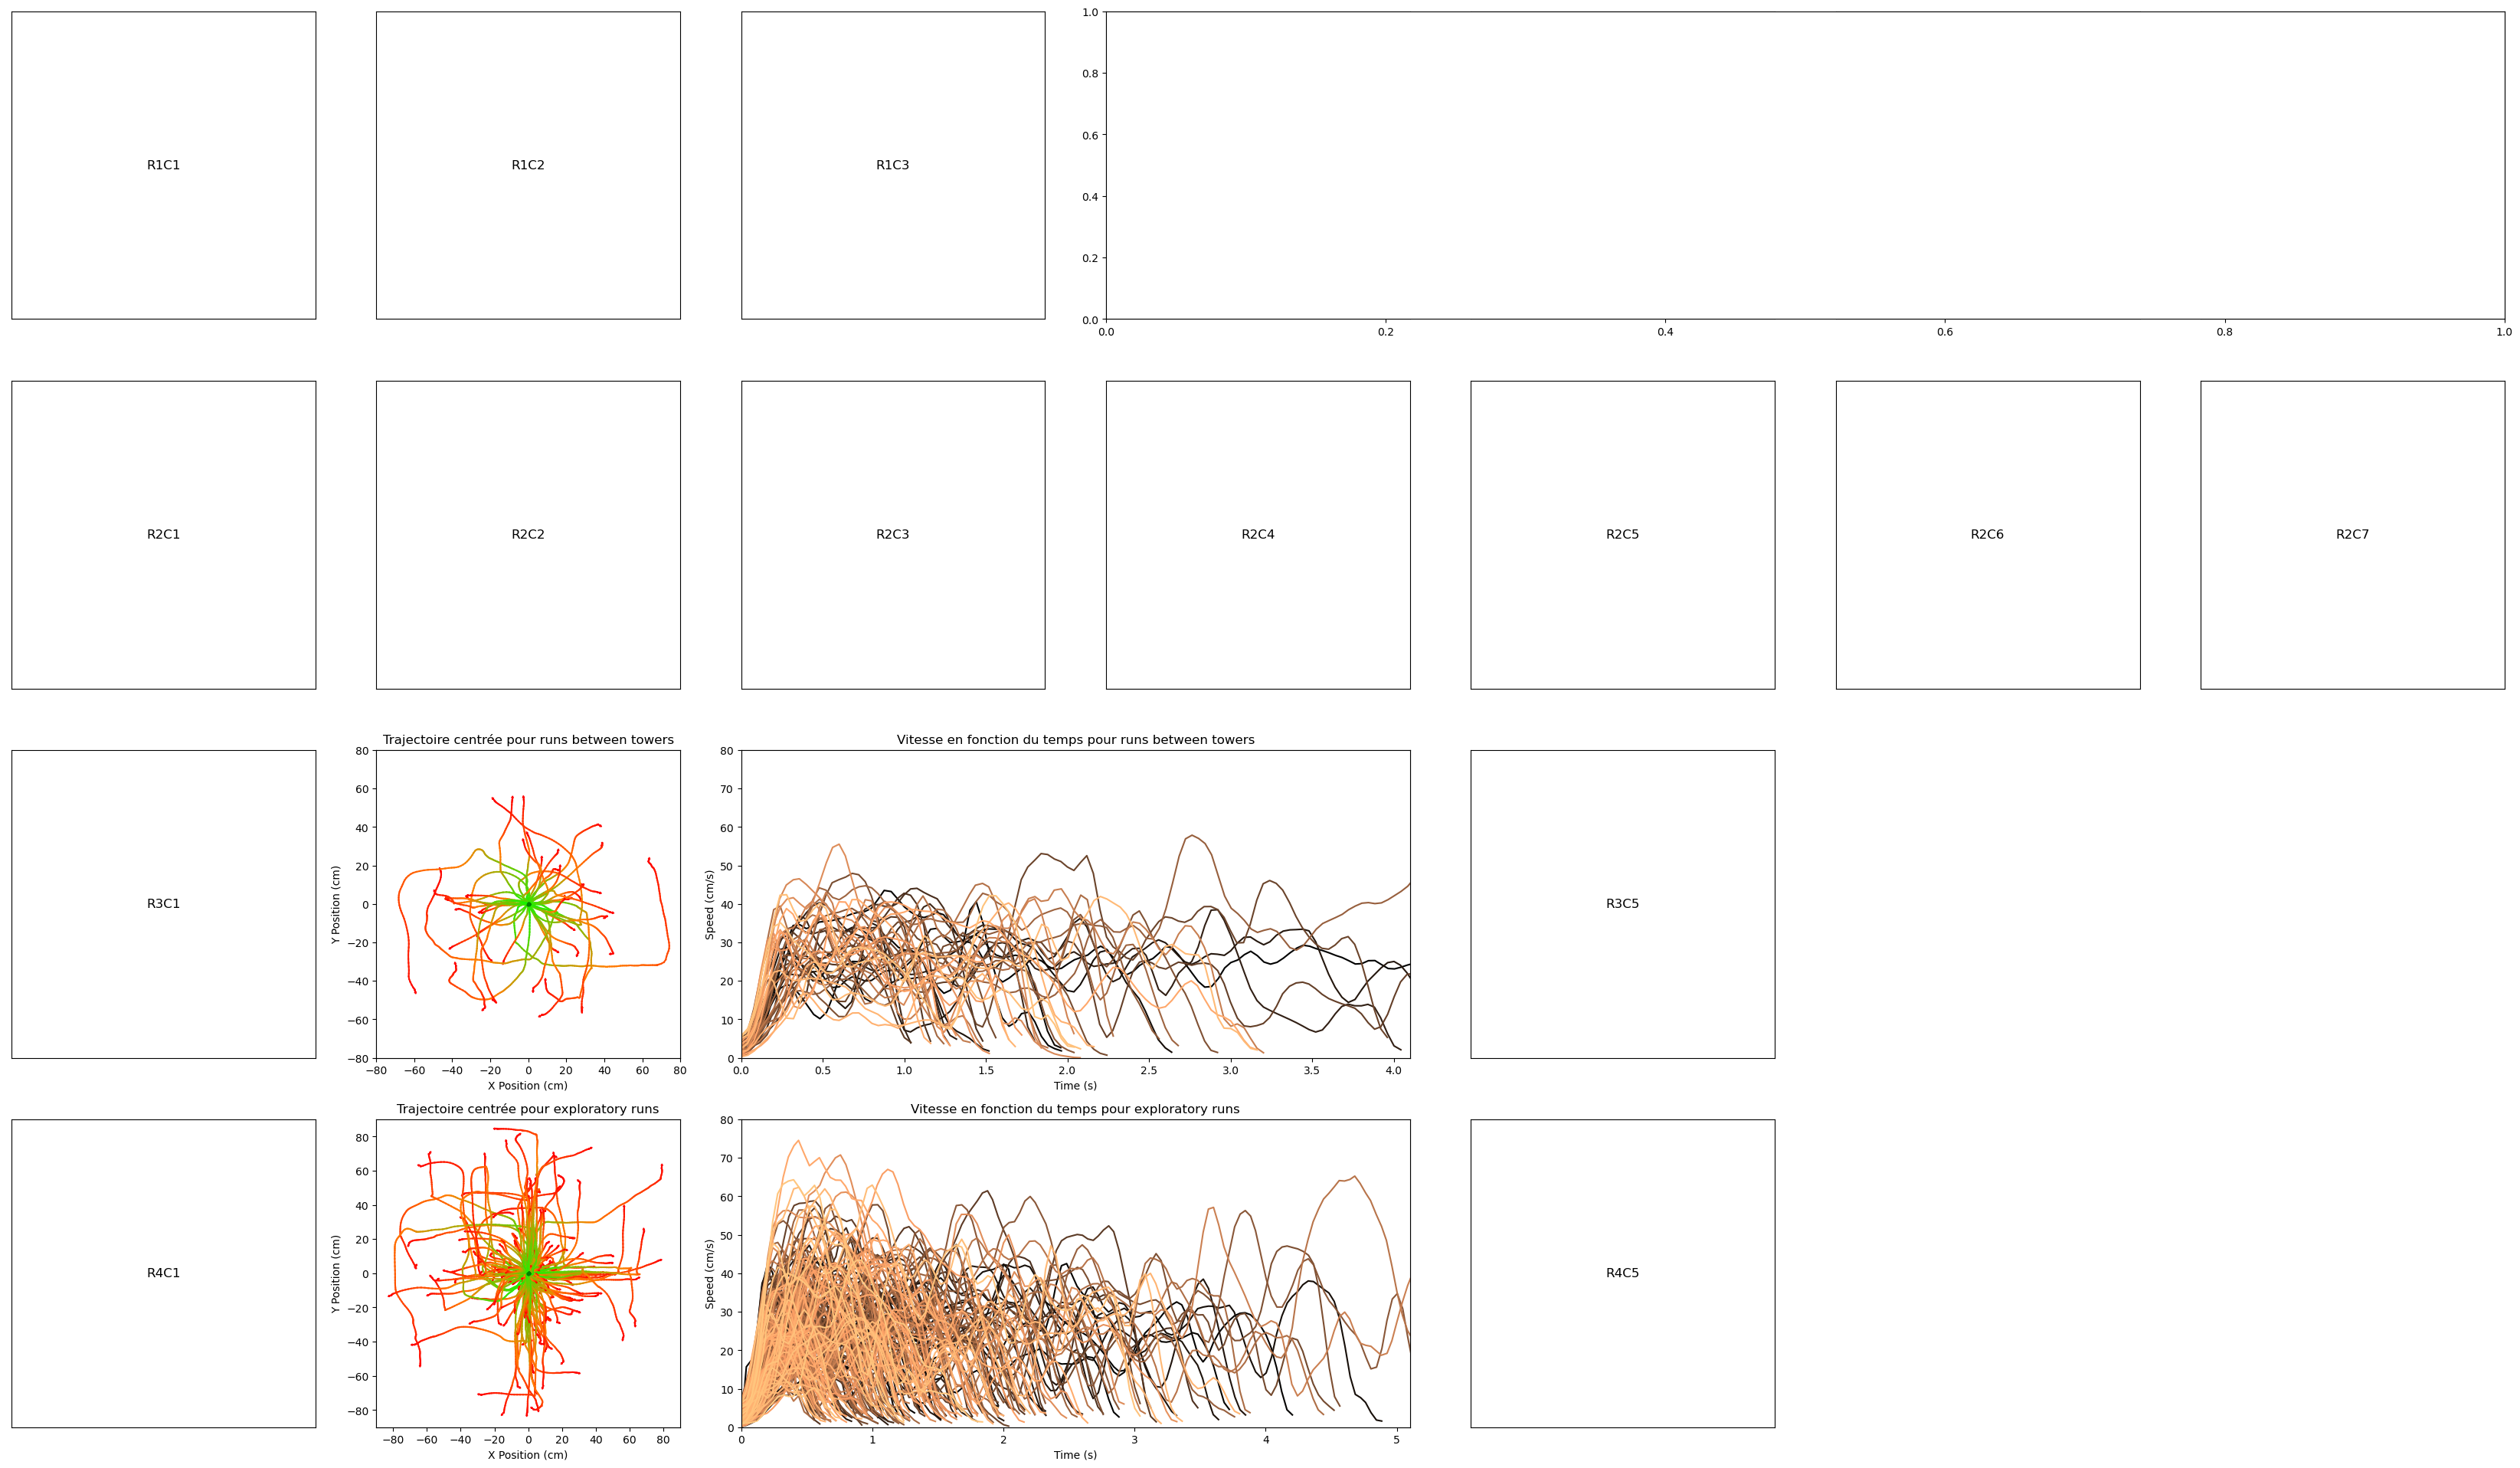

In [ ]:
# Creation of the grid
# Dimensions de chaque carré
square_size = 6
n_cols = 7
n_rows = 4

# Taille totale de la figure
figsize = (n_cols * square_size, n_rows * square_size)

# Création de la figure
fig = plt.figure(figsize=figsize)

# Utilisation de GridSpec pour une grille flexible
gs = GridSpec(n_rows, n_cols, figure=fig)

axes = []

# Lignes 1 et 2 : chaque case est un carré individuel
for row in range(2):
    for col in range(7):
        ax = fig.add_subplot(gs[row, col])
        ax.text(0.5, 0.5, f"R{row+1}C{col+1}", ha='center', va='center', fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])
        axes.append(ax)

# Lignes 3 et 4 :
for row in range(2, 4):
    # Colonnes 1, 2, 5 : cases individuelles
    for col in [0, 1, 4]:  
        ax = fig.add_subplot(gs[row, col])
        ax.text(0.5, 0.5, f"R{row+1}C{col+1}", ha='center', va='center', fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])
        axes.append(ax)

    # Combinaison des colonnes 3 et 4 en un rectangle pour ces lignes
    ax = fig.add_subplot(gs[row, 2:4])  
    ax.text(0.5, 0.5, f"R{row+1}C3-4", ha='center', va='center', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    axes.append(ax)

# Insertion des graphiques dans la grille
# Trajectoire dans la case de la colonne 2 et ligne 3
ax_trajectory = fig.add_subplot(gs[2, 1])  # Ligne 3, colonne 2
plot_trajectory_type_centered(ax_trajectory, X_positions_cm, Y_positions_cm, runs_between_towers, title_type='runs between towers')

# Profil de vitesse dans les colonnes 3-4 et ligne 3
ax_speed = fig.add_subplot(gs[2, 2:4])  # Ligne 3, colonnes 3 et 4 (combinées)
plot_speed_over_time(ax_speed, traject_time, speeds, runs_between_towers, title_type='runs between towers', xlim=4.1)

# Trajectoire dans la colonne 2, ligne 4
ax_trajectory = fig.add_subplot(gs[3, 1])  # Ligne 4, colonne 2
plot_trajectory_type_centered(ax_trajectory, X_positions_cm, Y_positions_cm, exploratory_runs, title_type='exploratory runs', axis_lim=90)

# Profil de vitesse dans les colonnes 3-4 et ligne 4
ax_speed = fig.add_subplot(gs[3, 2:4])  # Ligne 4, colonnes 3 et 4 (combinées)
plot_speed_over_time(ax_speed, traject_time, speeds, exploratory_runs, title_type='exploratory runs')

# Metrics in zones in columns 4-7 and lign 1
ax_metrics = fig.add_subplot(gs[0,3:7])
plot_metrics_in_zones([ax_metrics], zones, time_data, distance_data, speed_data, 
                      ratios_columns_titles, ratios_trapeze_over_border, 
                      colors_zones, colors_ratios)

# Espacement entre les sous-graphes
plt.tight_layout()
plt.show()
